Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Centrality Algorithms

Centrality algorithms utilize the topology of a network to determine the relative importance or influence of a specific node within the graph. By measuring the relative importance of a node or edge within a network, centrality values can indicate which elements in a graph play a critical role in that network.

By identifying the most influential or important nodes within a network, centrality algorithms can provide insights about key players or critical points of interaction. This is valuable in social network analysis, where it helps pinpoint influential individuals, and in transportation networks, where it aids in identifying crucial hubs for efficient routing and resource allocation.

Different types of centrality algorithms use different techniques to measure the importance of a node. Understanding how an algorithm calculates centrality is important to understanding the meaning of its outputs.

In addition to returning centrality data to the client, Neptune Analytics provides mutate variations of the centrality algorithms which store the calculated centrality values as vertex properties in the graph.
## Supported Algorithms

Neptune Analytics supports the following centrality algorithms, each of which has a few variants:

* [Degree](#Degree-Centrality) -  This measures a nodes's centrality by the number of edges connected to it, and can therefore be used to find the most connected nodes in a network.
* [PageRank](#PageRank-Centrality) -  This is an iterative algorithm that measures a nodes's centrality by the number and quality of incident edges and adjacent vertices. The centrality of a node connected to a few important nodes may therefore be higher than that of a node connected to many less important nodes. The output of this algorithm is a value that indicates the importance of a given node relative to the other nodes in the graph.
* [Closeness](#Closeness-Centrality) -   This algorithm computes the closeness centrality (CC) metric of nodes in a graph. The closeness centrality metric of a vertex is a positive measure of how close it is to all other vertices, or how central it is in the graph.

In addition to returning centrality data to the client, Neptune Analytics provides `mutate` variations of the centrality algorithms which store the calculated centrality values as a specified node property on each node in the graph.
    
## Loading Data
The first step in most projects is to load data to use for analysis.  For demonstration purposes, we have provided a set of datasets that can be used to demonstrate the features and functionality of Neptune Analytics. 

The cell below makes it easy to load the `air-routes` data into your graph.  The `air-routes` dataset we will be loading in this notebook is supplied as part of the [Practical Gremlin](https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html#air) book.

The `air-route`'s graph contains several vertex types that are specified using labels. The most common ones being `airport` and `country`. There are also nodes for each of the seven continents (`continent`) and a single `version` vertex that I provided as a way to test which version of the graph you are using.

Routes between airports are modeled as edges. These edges carry the `route` label and include the distance between the two connected airport vertices as a property called `dist`. Connections between countries and airports are modelled using an edge with a `contains` label.

Each `airport` vertex has many properties associated with it giving various details about that airport including its IATA and ICAO codes, its description, the city it is in and its geographic location. A full data model of the `air-route`s graph is below.

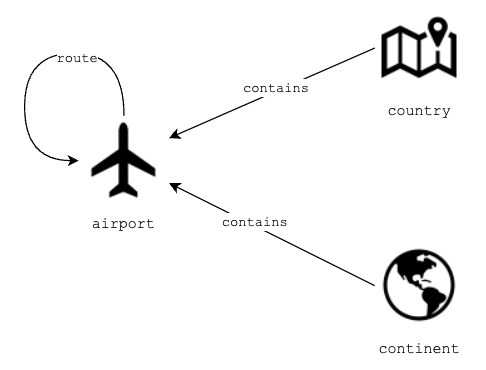

To load this dataset, run the two cells below.  This first cell will setup a few python variables using the configuration parameters of this Neptune Notebook.  The second cell will use Neptune Analytics batch load feature to load the data from the provided S3 bucket.  

**Note:** You only need to do this once. If you have already loaded the data previously you do not need to load it again.

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

s3_bucket = f"s3://aws-neptune-customer-samples-{config.aws_region}/sample-datasets/gremlin/air-routes/"
region = config.aws_region

In [ ]:
%%oc 

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

## Degree Centrality
Degree centrality is calculated by counting the number of incident edges at each node that it traverses. This measure of how connected the node which can indicate the node's importance and level of influence in the network.

Some common uses of degree centrality are:

- Identifying influential nodes in a network - Degree centrality can help identify the most connected or influential nodes in a social network, information network, etc. Nodes with high degree centrality have more potential to spread information or influence others.

- Analyzing collaboration networks - In co-authorship or other collaboration networks, degree centrality identifies the most collaborative individuals. Those with high degree centrality have worked with many others.

- Prioritizing marketing efforts - In identity graphs, degree centrality can help identify highly connected "influencers" that companies may want to target for marketing campaigns or word-of-mouth promotion. 

- Detecting hubs in infrastructure - For transportation, internet, power grid networks etc., degree centrality finds the most critical connection points that distribute traffic/load across the network.

- Identifying key nodes for robustness - Networks are more vulnerable if they rely too heavily on a few high-degree nodes. Degree centrality analysis helps assess this and identify nodes to protect.

- Analyzing disease spread - In contact networks, individuals with high degree centrality are likely to spread diseases more quickly if infected.

To summarize, degree centrality is useful for finding influential, collaborative, critical, and vulnerable nodes in many real-world networks.

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a best practice</i></b></summary>
  
Every source node runs it's own execution of the algorithm.  Let's look at what this means using the query below.
    
```
MATCH (a:airport {region: 'US-WA'})
CALL neptune.algo.degree(a)
YIELD node, degree
RETURN node, degree
```
In this example that means that the `degree` algorithm would be executed 9 times, one for each `airport` in the region `US-WA`.  When large numbers of nodes are returned from the `MATCH` clause, the performance of the query will be impacted.
    
It is best practice to limit the number of source nodes as much as possible.    
</details>
</div>

### `degree`

Degree is an algorithm for finding nodes which have the most connections in the graph

Using our air routes data, let's find the 10 most important airports, defined by the largest number of flights.

In [ ]:
%%oc

MATCH (n)
CALL neptune.algo.degree(n, {edgeLabels: ["route"]})
YIELD node, degree
RETURN node.code, node.desc, degree ORDER BY degree DESC LIMIT 10

Looking at this data we can see that the Istanbul airport is the most important one in our airplane transportation network.  Anyone that has flown threw the Istanbul airport will certainly agree that it is definitely a very busy and central place for international air travel.

### `degree.mutate`

In addition to the `degree` algorithm above there is a variant of the algorithm that stores the output value of the algorithm as to a property of each node, which is specified by the `writeProperty` parameter.

Let's see how we can use the `mutate` version and openCypher queries to answer the same question, find the 10 most important airports, defined by the largest number of flights.

In [ ]:
%%oc

CALL neptune.algo.degree.mutate({edgeLabels: ["route"], writeProperty: 'degree'})

In [ ]:
%%oc

MATCH (a:airport)
RETURN a.code, a.desc, a.degree 
ORDER by a.degree DESC LIMIT 10

As we see, both options return the same result. Using the `mutate` versions of algorithms is a very efficent way to store the algorithm output values to each node for later analysis by openCypher queries.  This is especially helpful when performing analysis on larger graphs where these calculations can be performed one time and reused across multiple queries.

## PageRank Centrality

PageRank is an algorithm originally developed by Larry Page and Sergey Brin, co-founders of Google. It was originally developed to rank web pages in search engine results. The PageRank score for a given node is calculated based on the number and quality of the edges pointing to that node, as well as the importance of the nodes that are connected to it. The PageRank algorithm assigns a higher score to nodes that are linked to other high-scoring nodes, and a lower score to nodes that are linked to low-scoring nodes.

The output of PageRank can be visualized as a ranking metric for the importance of a node within a given graph, with the most important nodes having the highest score, and the least important node having the lowest score. PageRank is used in search engines to rank web pages based on their importance and influence, in citation networks to identify highly cited scientific papers, and in recommendation systems to suggest popular and relevant content to users.


Some common uses of the PageRank:

- Search engine ranking - The original and most well-known application of PageRank is for ranking web pages in search engines like Google. It helps determine which pages are more important and relevant to display higher in search results.

- Identifying influential nodes in networks - PageRank identifies the most influential or important nodes based on their connections, such key influencers on social media.

- Recommendation systems - PageRank scores can help power recommendations by identifying popular or well-connected items that others may be interested in based on their preferences and connections. 

- Detecting important topics/concepts - When applied to knowledge graphs extracted from text, PageRank helps identify the core and most central topics discussed. 

- Fraud/anomaly detection - Deviations from the typical PageRank scores can help identify potentially fraudulent or anomalous nodes in networks by identify them due to their outsized influence.

Anytime you need to analyze a networked system and identify the most important or influential components, PageRank can provide useful insights.

### `pageRank`

Degree is an algorithm for finding the relative importance of the nodes in the graph by counting the number and quality of connections to the node.  The underlying assumption is that the more important a node, the more connected that node will be and the higher the importance of those connections will be.  A node linked to many nodes of low importance will be ranked lower than a node with fewer connections, but those connections are more important.

Using our air routes data, let's find the 10 most important airports, defined by their relative importance.

In [ ]:
%%oc

MATCH (n)
CALL neptune.algo.pageRank(n, {edgeLabels: ["route"]})
YIELD node, rank
RETURN node.code, node.desc, rank ORDER BY rank DESC LIMIT 10

If we compare the output of this algorithm to the output of our `degree` algorithm we see that while Istanbul is still the top ranked in both, many of the other top ten have shifted in their ranking and a few, such as Amsterdam, have been replaced.

### `pageRank.mutate`

As with `degree.mutate` a variant of PageRank exists, `pageRank.mutate` which will store the values of algorithm into a property on the node.

In [ ]:
%%oc
CALL neptune.algo.pageRank.mutate({edgeLabels: ["route"], writeProperty: 'pageRank'})

## Closeness Centrality
The closeness centrality algorithm computes a Closeness Centrality (CC) metric for specified nodes in a graph. The CC metric of a node can be used as a positive measure of how close it is to all other nodes or how central it is in the graph.

The CC metric can be interpreted to show how quickly all other nodes in a network can be reached from a given node, and how important it is as a central hub for rapid information flow. It can be used in transportation networks to identify key hub locations, and in disease-spread modeling to pinpoint central points for targeted intervention efforts.

The closeness centrality (CC) score of a node is calculated based on the sum of its distances to all other nodes. The CC score itself is the inverse of that number; in other words, one divided by that sum. In practice, the calculation is commonly normalized to use the average length of the shortest paths rather than the actual sum of their lengths.

 Some common uses of the closeness centrality algorithm:

- Identifying influential nodes in a network - Nodes with high closeness centrality are able to spread information to others in the network quickly. This could identify influential individuals.

- Recommendation systems - Products or users with high closeness centrality in a user-item network are more likely to reach a broader set of users quickly. 

- Traffic analysis - Nodes with high closeness in a transportation network are critical junctions that facilitate flow. Their disruption could significantly impact traffic.

- Key player identification - In collaboration or organizational networks, individuals with high closeness play an important coordinating role in connecting different parts of the network.

- Prioritizing nodes for network robustness - Nodes with high closeness centrality are single-point-of-failures. Reinforcing them can make the network more robust against failures.

Closeness centrality is useful for finding influential, central or critical nodes for spreading, connecting, or coordinating processes on networks.


### `closenessCentrality`

Closeness centrality is a measure of centrality in a network that is based on the average shortest path distance between a node and all other nodes in the network. To calculate closeness centrality for a node, the shortest paths are found from that node to all other nodes and the score for the node is then calculated as the inverse of the average shortest path length to all other nodes. Nodes with higher closeness centrality have shorter average distances to all other nodes in the network. Closeness centrality helps identify nodes that have the most efficient access to all parts of the network.

Using our air routes data, let's find the 10 most important airports, defined by their closeness.

In [ ]:
%%oc

MATCH (n)
CALL neptune.algo.closenessCentrality(n, {edgeLabels: ["route"], numSources:8192})
YIELD node, score
RETURN node.code, node.desc, score ORDER BY score DESC LIMIT 10

Again, If we compare the output of this algorithm to the output of our `degree` and `pageRank` algorithms we see that the ordering has changed, e.g. Istanbul is now 10th instead of 1st, and that several have been replaced.

As each of these algorithms defines centrality in slightly different ways, this is to be expected.

### `closenessCentrality.mutate`

As with `degree.mutate` and `pageRank.mutate` a variant of Closeness exists, `closenessCentrality.mutate` which will store the values of algorithm into a property on the node.

In [ ]:
%%oc
CALL neptune.algo.closenessCentrality.mutate({edgeLabels: ["route"], writeProperty: 'closeness', numSources:8192})

## Next Steps
In this notebook, we have demonstrated how to use the centrality algorithms provided by Neptune Analytics.  If you are interested in the other types of algorithms offered please look at the other notebooks available:

* [Path finding algorithms](./02-Path-Finding-Algorithms.ipynb)

* [Community detection/clustering algorithms](./04-Community-Detection-Algorithms.ipynb)

* [Similarity algorithms](./05-Similarity-Algorithms.ipynb)